In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors
from sklearn.preprocessing import StandardScaler
from utils import LATENT_FEATURES_DIR, RESULTS_DIR, SUBJECTS, FMRI_BETAS_SURFACE_DIR, STIM_INFO_PATH, COCO_IMAGES_DIR, METRIC_DIFF_MOD_AGNOSTIC_MOD_SPECIFIC, METRIC_CROSS_DECODING, DECODER_ADDITIONAL_TEST_OUT_DIR, SUBJECTS_ADDITIONAL_TEST, FMRI_DATA_DIR
from analyses.decoding.ridge_regression_decoding import NUM_CV_SPLITS, pairwise_accuracy
from data import MODALITY_AGNOSTIC, MODALITY_SPECIFIC_IMAGES, MODALITY_SPECIFIC_CAPTIONS, TRAINING_MODES, CAPTION, IMAGE, SPLIT_TRAIN, TEST_SPLITS, SPLIT_IMAGERY, SPLIT_IMAGERY_WEAK, TEST_IMAGES, TEST_CAPTIONS, LatentFeatsConfig, get_stim_info, get_latents_for_splits, standardize_latents
from eval import ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, ACC_CROSS_IMAGES_TO_CAPTIONS, ACC_CROSS_CAPTIONS_TO_IMAGES, ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST, get_distance_matrix
from scipy.stats import ttest_rel
import statsmodels.formula.api as smf
from scipy.spatial.distance import cdist

from notebook_utils import load_predictions

In [2]:
def load_results_data():
    data = []

    result_files = sorted(glob(f"{DECODER_ADDITIONAL_TEST_OUT_DIR}/*/*/*/results.csv"))
    for result_file_path in tqdm(result_files):
        results = pd.read_csv(result_file_path)
        data.append(results)

    data = pd.concat(data, ignore_index=True)
    data["mask"] = data["mask"].fillna("whole_brain")

    return data

data = load_results_data()

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
display(data)

print(f"Subjects: {data.subject.unique()}")

100%|██████████| 86/86 [00:00<00:00, 115.16it/s]


,metric,value,standardized_predictions,latents,model,subject,features,test_features,vision_features,lang_features,training_mode,training_splits,mask,num_voxels,surface,resolution,imagery_samples_weight
0,test_image,0.901863,True,limited_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,133499,False,fsaverage7,NaN
1,test_image,0.896273,False,limited_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,133499,False,fsaverage7,NaN
2,test_image,0.903044,True,all_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,133499,False,fsaverage7,NaN
3,test_image,0.911358,False,all_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,133499,False,fsaverage7,NaN
4,test_caption,0.759627,True,limited_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,133499,False,fsaverage7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2919,imagery_weak,0.899592,True,limited_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,train,whole_brain,327684,True,fsaverage7,NaN
2920,imagery_weak,0.648361,False,all_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,train,whole_brain,327684,True,fsaverage7,NaN
2921,imagery_weak,0.885574,True,all_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,train,whole_brain,327684,True,fsaverage7,NaN
2922,imagery,0.666667,all_imagery,limited_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,train,whole_brain,327684,True,fsaverage7,NaN


Subjects: ['sub-01' 'sub-02' 'sub-04' 'sub-05' 'sub-07']


In [3]:
print(data[(data.subject == 'sub-01') & (data.model == 'imagebind') & (data.training_mode == 'agnostic') & (data['mask'] == 'whole_brain') & (data.standardized_predictions == 'True') & (data.training_splits == 'train')][['metric', 'value', 'latents']]) #
# print(data[(data.subject == 'sub-01') & (data.model == 'imagebind') & (data.training_mode == 'agnostic') & (data['mask'] == 'whole_brain') & (data.training_splits == 'train') & (data.latents == 'all_candidate_latents')][['metric', 'value', 'latents', 'standardized_predictions']]) #

                      metric     value                    latents
0                 test_image  0.901863  limited_candidate_latents
2                 test_image  0.903044      all_candidate_latents
4               test_caption  0.759627  limited_candidate_latents
6               test_caption  0.763115      all_candidate_latents
8        test_image_attended  0.905590  limited_candidate_latents
10       test_image_attended  0.907143      all_candidate_latents
12     test_caption_attended  0.817598  limited_candidate_latents
14     test_caption_attended  0.816628      all_candidate_latents
16     test_image_unattended  0.896894  limited_candidate_latents
18     test_image_unattended  0.899180      all_candidate_latents
20   test_caption_unattended  0.628571  limited_candidate_latents
22   test_caption_unattended  0.628220      all_candidate_latents
24                   imagery  1.000000  limited_candidate_latents
26                   imagery  0.844262      all_candidate_latents
28        

In [4]:
filtered = data.copy()

# LATENT_MODE = 'all_candidate_latents'
LATENT_MODE = 'limited_candidate_latents'
MASK = 'whole_brain'
TRAINING_SPLITS = 'train'
MODEL = 'imagebind'

filtered = filtered[filtered.model == MODEL]
filtered = filtered[filtered.standardized_predictions == 'True']
filtered = filtered[filtered.training_splits == TRAINING_SPLITS]
filtered = filtered[filtered.latents == LATENT_MODE]
filtered = filtered[filtered['mask'] == MASK]
filtered = filtered[filtered.imagery_samples_weight.isna()]
filtered = filtered[filtered.surface == True]

# print(filtered.groupby(['metric', 'training_mode']).agg(num_subjects=('value', 'size')).reset_index())
NUM_SUBJECTS = len(SUBJECTS_ADDITIONAL_TEST)
expected_len = NUM_SUBJECTS * len(filtered.metric.unique()) * len(filtered.training_mode.unique())
assert len(filtered) == expected_len, filtered

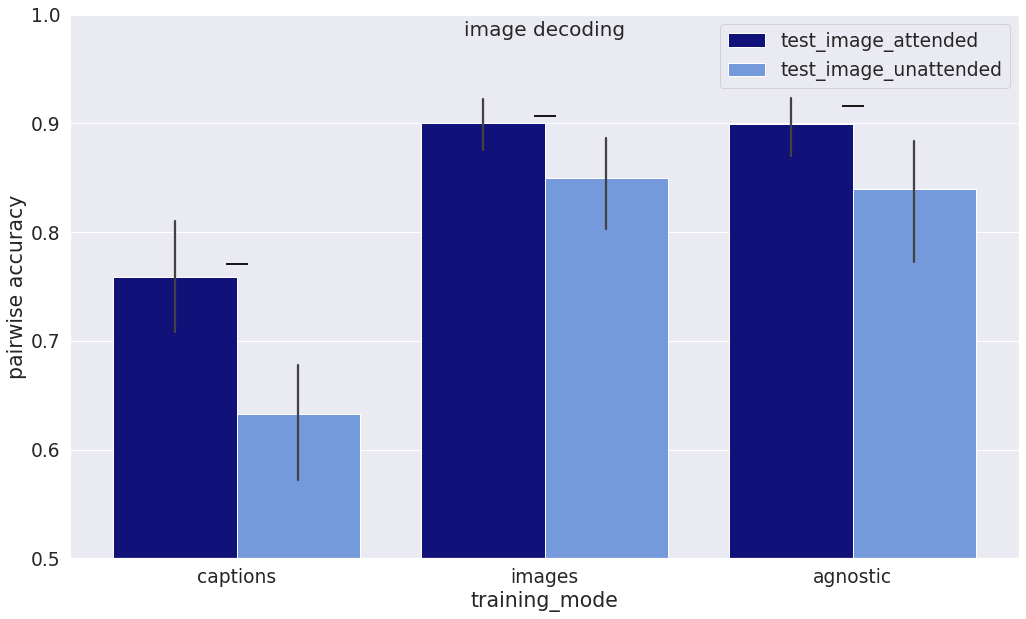

In [5]:
to_plot = filtered.copy()

ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = ['test_image_attended', 'test_image_unattended']#, 'imagery', 'imagery_weak'] #'test_image', 
PALETTE = ['darkblue', 'cornflowerblue'] #blue

to_plot = to_plot[to_plot.metric.isin(HUE_ORDER)]

sns.set(font_scale=1.7)
plt.figure(figsize=(17, 10))
plt.title('image decoding', y=0.95, fontsize=20)
ax = sns.barplot(data=to_plot, x="training_mode", y="value", hue="metric", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylim((0.5, 1))
plt.ylabel('pairwise accuracy')


ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = ['test_image']
to_plot_grouped = filtered.copy()
to_plot_grouped = to_plot_grouped[to_plot_grouped.metric.isin(HUE_ORDER)]
to_plot_grouped = to_plot_grouped.groupby(['training_mode']).agg(value=('value', 'mean')).reset_index()
# display(to_plot)
sns.scatterplot(data=to_plot_grouped, x="training_mode", y="value", marker="_", color='black', s=500)

plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_images.png"), bbox_inches='tight', pad_inches=0, dpi=300)



## hypothesis: mod-agnostic decoders (and cross-decoding) should suffer more from missing attention

In [6]:
for_stats = to_plot[to_plot.training_mode.isin(['images', 'agnostic'])]
# display(for_stats)
# print(ttest_rel(for_stats[for_stats.metric == 'test_image_attended'].value, for_stats[for_stats.metric == 'test_image_unattended'].value))

for_stats = for_stats[['model', 'subject', 'training_mode', 'value', 'metric']]

mod = smf.mixedlm("value ~ metric * training_mode", for_stats, groups=for_stats["subject"]).fit()

print(mod.summary())
print('pvalues:\n', mod.pvalues)
print('\n')


                              Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                value  
No. Observations:                20                     Method:                            REML   
No. Groups:                      5                      Scale:                             0.0017 
Min. group size:                 4                      Log-Likelihood:                    22.7010
Max. group size:                 4                      Converged:                         Yes    
Mean group size:                 4.0                                                              
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

/home/mitja/anaconda3/envs/multimodal_decoding_additional_test/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


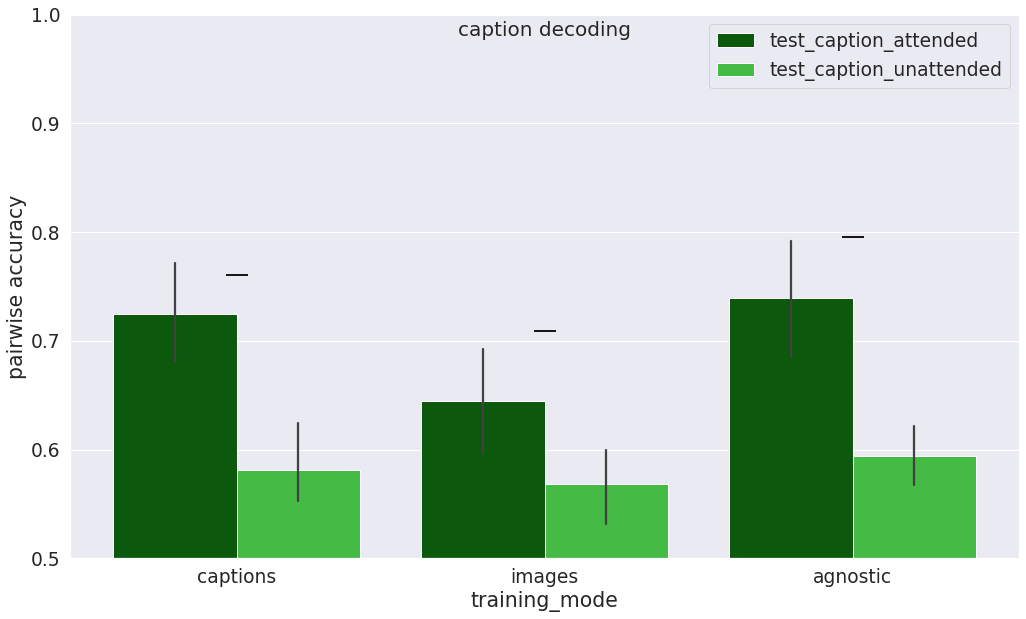

In [7]:
to_plot = filtered.copy()

ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = ['test_caption_attended', 'test_caption_unattended']#, 'imagery', 'imagery_weak'] #'test_caption', 
PALETTE = ['darkgreen', 'limegreen'] #'green', 

to_plot = to_plot[to_plot.metric.isin(HUE_ORDER)]

sns.set(font_scale=1.7)
plt.figure(figsize=(17,10))
plt.title('caption decoding', y=0.95, fontsize=20)
ax = sns.barplot(data=to_plot, x="training_mode", y="value", hue="metric", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylabel('pairwise accuracy')
plt.ylim((0.5, 1))

ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = ['test_caption']
to_plot_grouped = filtered.copy()
to_plot_grouped = to_plot_grouped[to_plot_grouped.metric.isin(HUE_ORDER)]
# display(to_plot)

to_plot_grouped = to_plot_grouped.groupby(['training_mode']).agg(value=('value', 'mean')).reset_index()

sns.scatterplot(data=to_plot_grouped, x="training_mode", y="value", marker="_", color='black', s=500)

plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_captions.png"), bbox_inches='tight', pad_inches=0, dpi=300)


In [8]:
for_stats = to_plot[to_plot.training_mode.isin(['captions', 'agnostic'])]
# print(ttest_rel(for_stats[for_stats.metric == 'test_caption_attended'].value, for_stats[for_stats.metric == 'test_caption_unattended'].value))

for_stats = for_stats[['model', 'subject', 'training_mode', 'value', 'metric']]

mod = smf.mixedlm("value ~ metric * training_mode", for_stats, groups=for_stats["subject"]).fit()

print("=" * 50 + "\nGLM\n" + "=" * 50)
print(mod.summary())
print('pvalues:\n', mod.pvalues)
print('\n')



GLM
                                Mixed Linear Model Regression Results
Model:                             MixedLM                 Dependent Variable:                 value  
No. Observations:                  20                      Method:                             REML   
No. Groups:                        5                       Scale:                              0.0011 
Min. group size:                   4                       Log-Likelihood:                     24.6508
Max. group size:                   4                       Converged:                          Yes    
Mean group size:                   4.0                                                                
------------------------------------------------------------------------------------------------------
                                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------------

/home/mitja/anaconda3/envs/multimodal_decoding_additional_test/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
